In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
cd ~/foregrounds/gbt/

/home/mabitbol/foregrounds/gbt


In [3]:
import foregrounds as fg
from scipy.optimize import curve_fit

In [4]:
fdg = np.fromfile('/home/mabitbol/notebooks/aether_notebooks/images/g107.dat', sep='\t')

In [5]:
cfs = fdg[::6]
cjys = fdg[1::6]
cerrs = fdg[2::6]
cfit = fdg[3::6]
crem = fdg[4::6]
cremerr = fdg[5::6]

In [6]:
freqs = np.logspace(8, 13, 2000)
nu = freqs*1.e-9
gfs = np.linspace(4.5, 7.5, 4)*1.e9
gfs = np.concatenate([gfs, np.linspace(12.5, 17.5, 6)*1.e9])

In [7]:
beam = pi*(1.*pi/180.)**2
beam2 = pi*((0.16/60.)*pi/180.)**2

In [8]:
def freefreep(freqs, EM=100., Te=8000.):
    nu = freqs*1.e-9
    gff = np.log(4.955e-2 / nu) + 1.5 * np.log(Te)
    tff = 3.014e-2 * (Te**-1.5) * (nu**-2) * EM * gff
    return Te * (1. - np.exp(-tff))

In [9]:
def signal(freqs, EM, Ad, Bd, Asd, nup, A):
    fffit = freefreep(freqs, EM=EM, Te=8000.)
    fffit = fg.krj_to_radiance(freqs, fffit)*1.e26*beam
    dustfit = fg.thermal_dust(freqs, Ad=Ad, Bd=Bd, Td=18.96)
    dustfit = fg.krj_to_radiance(freqs, dustfit)*1.e26*beam
    amefit = fg.ame(freqs, Asd=Asd, nup=nup, nu0=22.8e9)
    amefit = fg.krj_to_radiance(freqs, amefit)*1.e26*beam
    ccmb = fg.cmb(freqs, A=A)
    ccmb = fg.krj_to_radiance(freqs, ccmb)*1.e26*beam
    total = fffit + dustfit + amefit + ccmb
    return total

In [10]:
def signalame(freqs, EM, Ad, Bd, Asd, nup, A):
    fffit = freefreep(freqs, EM=EM, Te=8000.)
    fffit = fg.krj_to_radiance(freqs, fffit)*1.e26*beam
    dustfit = fg.thermal_dust(freqs, Ad=Ad, Bd=Bd, Td=18.96)
    dustfit = fg.krj_to_radiance(freqs, dustfit)*1.e26*beam
    amefit = fg.ame(freqs, Asd=Asd, nup=nup, nu0=22.8e9)
    amefit = fg.krj_to_radiance(freqs, amefit)*1.e26*beam
    ccmb = fg.cmb(freqs, A=A)
    ccmb = fg.krj_to_radiance(freqs, ccmb)*1.e26*beam
    total = fffit + dustfit + amefit + ccmb
    return total, amefit, fffit

In [11]:
def signal2(freqs, EM1, EM2, Ad, Bd):
    fffit = freefreep(freqs, EM=EM1, Te=8000.)
    fffit = fg.krj_to_radiance(freqs, fffit)*1.e26*beam
    fffit2 = freefreep(freqs, EM=EM2, Te=8000.)
    fffit2 = fg.krj_to_radiance(freqs, fffit2)*1.e26*beam2
    dustfit = fg.thermal_dust(freqs, Ad=Ad, Bd=Bd, Td=18.96)
    dustfit = fg.krj_to_radiance(freqs, dustfit)*1.e26*beam
    return fffit + fffit2 + dustfit

In [12]:
def signal2ff(freqs, EM1, EM2, Ad, Bd):
    fffit = freefreep(freqs, EM=EM1, Te=8000.)
    fffit = fg.krj_to_radiance(freqs, fffit)*1.e26*beam
    fffit2 = freefreep(freqs, EM=EM2, Te=8000.)
    fffit2 = fg.krj_to_radiance(freqs, fffit2)*1.e26*beam2
    dustfit = fg.thermal_dust(freqs, Ad=Ad, Bd=Bd, Td=18.96)
    dustfit = fg.krj_to_radiance(freqs, dustfit)*1.e26*beam
    return fffit + fffit2 + dustfit, fffit, fffit2

In [13]:
pn = np.array([200., 80.e-5, 2., 1.e-3, 20.e9, 30.e-6])
x = curve_fit(signal, cfs*1.e9, cjys, p0=pn, sigma=cerrs, absolute_sigma=True)
pfit = x[0]
sig, amefit, ff_fit0 = signalame(freqs, *pfit)

In [14]:
pn2 = np.array([145. , 1.e7, 50.e-5, 2.])
y = curve_fit(signal2, cfs*1.e9, cjys, p0=pn2, sigma=cerrs, absolute_sigma=True)
pfit2 = y[0]
sig2, ff_fit, ff_fit2 = signal2ff(freqs, *pfit2)

In [15]:
gf2 = gfs*1.e-9
sprd = 0.01
off = 0.1

In [16]:
gdata1 = signal(gfs, *pfit)
gerrs1 = sprd * gdata1
offset1 = off * gdata1
spread = np.zeros(len(gfs))
for k in range(len(gfs)):
    spread[k] = np.random.normal(scale=gerrs1[k])
gdata1 += spread

In [17]:
gdata2 = signal2(gfs, *pfit2)
gerrs2 = sprd * gdata2
offset2 = off * gdata2
spread2 = np.zeros(len(gfs))
for k in range(len(gfs)):
    spread2[k] = np.random.normal(scale=gerrs2[k])
gdata2 += spread2

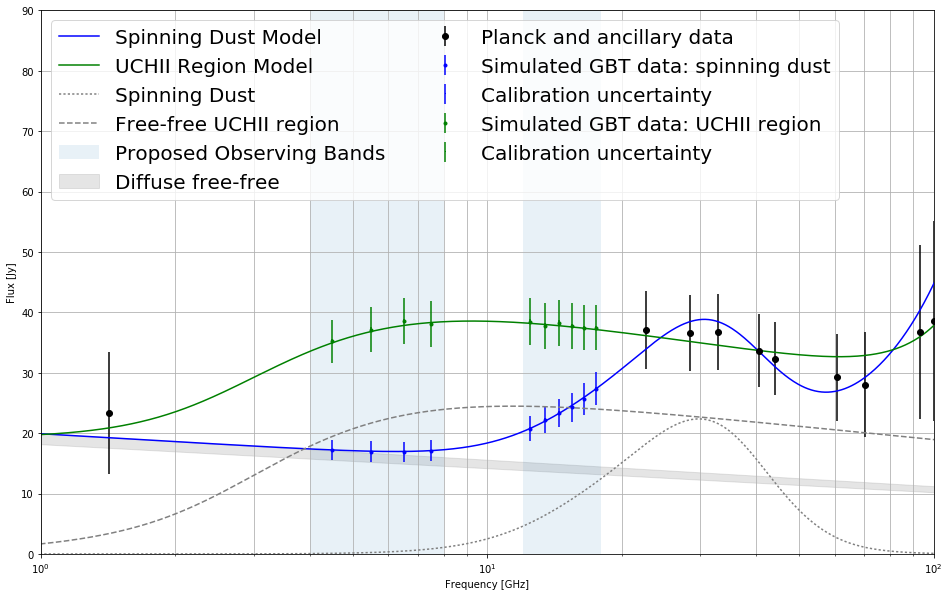

In [22]:
figure(figsize=(16,10))
plot(nu, sig, 'b', label='Spinning Dust Model')
plot(nu, sig2, 'g', label='UCHII Region Model')
plot(nu, amefit, color='grey', alpha=1., linestyle='dotted', label='Spinning Dust')
#plot(nu, ff_fit0, 'b--', label='Free-free SD')
fill_between(nu, ff_fit, ff_fit0, alpha=0.2, color='grey', label='Diffuse free-free')
#plot(nu, ff_fit, 'r--', label='Free-free')
plot(nu, ff_fit2, color='grey', alpha=1., linestyle='dashed', label='Free-free UCHII region')
errorbar(cfs, cjys, yerr=cerrs, fmt='ko', label='Planck and ancillary data')
errorbar(gf2, gdata1, yerr=gerrs1, fmt='b.', label='Simulated GBT data: spinning dust')
errorbar(gf2, gdata1, yerr=offset1, fmt='b,', capsize=0, label='Calibration uncertainty')
errorbar(gf2, gdata2, yerr=gerrs2, fmt='g.', label='Simulated GBT data: UCHII region')
errorbar(gf2, gdata2, yerr=offset2, fmt='g,', capsize=0, label='Calibration uncertainty')
axvspan(4., 8., alpha=0.1)
axvspan(12., 18., alpha=0.1, label='Proposed Observing Bands')
xscale('log')
ylim([0, 90])
xlim([1, 100])
xlabel('Frequency [GHz]')
ylabel('Flux [Jy]')
legend(loc=2, ncol=2, fontsize=20)
grid()
grid(which='minor')